In [50]:
%matplotlib inline

import os
import sys
import copy
import time
import pickle
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

# pycupid
from pycupid import *

# just for presentation
import warnings
warnings.filterwarnings("ignore")

target_path = '/Users/martin/Dropbox/Aplicaciones/ShareLaTeX/VarClump/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Synthetic example

Gaussian function:
$$
f(x,y) = A \cdot \exp \left(- \left( a(x-x_0)^2 - 2b(x-x_0)(y-y_0) + c(y-y_0)^2 \right) \right)
$$

In [51]:
def gaussian2D(A, mu, sig, dims=(150,150)):
    x = np.linspace(0., 1., dims[0]+2)[1:-1]
    y = np.linspace(0., 1., dims[1]+2)[1:-1]
    X,Y = np.meshgrid(x,y)
    _X = X-mu[0]
    _Y = Y-mu[1]
    a = sig[0]; b=sig[1]; c=sig[2]
    return A * np.exp(- (a*_X**2 - 2*b*_X*_Y + c*_Y**2))

In [49]:
np.random.seed(0)

g0 = gaussian2D(0.20, [0.7,0.3], [400,20,200])
g1 = gaussian2D(0.20, [0.63,0.35], [600,75,50])
g2 = gaussian2D(0.22, [0.52,0.38], [100,20,200])
g3 = gaussian2D(0.13, [0.6,0.2], [800,10,900])
g4 = gaussian2D(0.17, [0.78,0.3], [1000,20,900])
g5 = gaussian2D(0.17, [0.72,0.42], [800,30,1000])
g6 = gaussian2D(0.17, [0.40,0.75], [100,20,70])
g7 = gaussian2D(0.21, [0.25,0.8], [80,20,100])

dims = (150,150)
noise_level = 0.01
noise = noise_level * np.abs(np.random.randn(*dims))
mean_noise = np.mean(noise)
rms_noise = estimate_rms(noise)
var_noise = np.std(noise)**2

data = g0+g1+g2+g3+g4+g5+g6+g7+noise
data -= data.min()
data /= data.max()

x = np.linspace(0., 1., data.shape[0]+2, endpoint=True)[1:-1]
y = np.linspace(0., 1., data.shape[1]+2, endpoint=True)[1:-1]
dfunc = RegularGridInterpolator((x,y), data, method='linear', bounds_error=False, fill_value=0.)

In [29]:
print(mean_noise)
print(rms_noise)
print(var_noise)

0.00788910962357
0.00991130050008
3.59958269502e-05


### Noise distribution

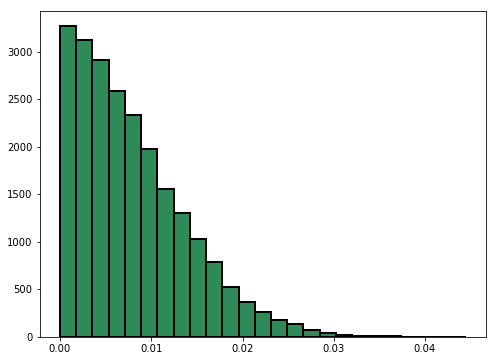

In [30]:
plt.figure(figsize=(8,6))
plt.hist(noise.ravel(), bins=25, facecolor='seagreen', edgecolor='black', lw=2)
plt.show()

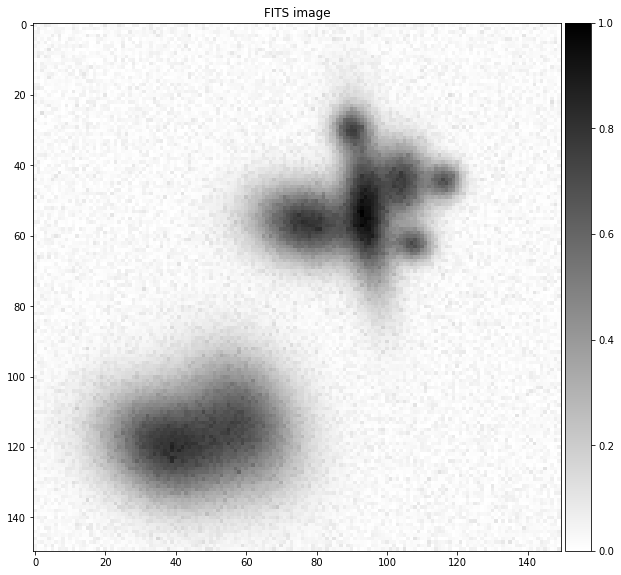

In [31]:
image_plot(data)

In [32]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=rms_noise ,max=1.,step=0.005,value=base_level));

### Some test with the `base_level` and the usable pixels

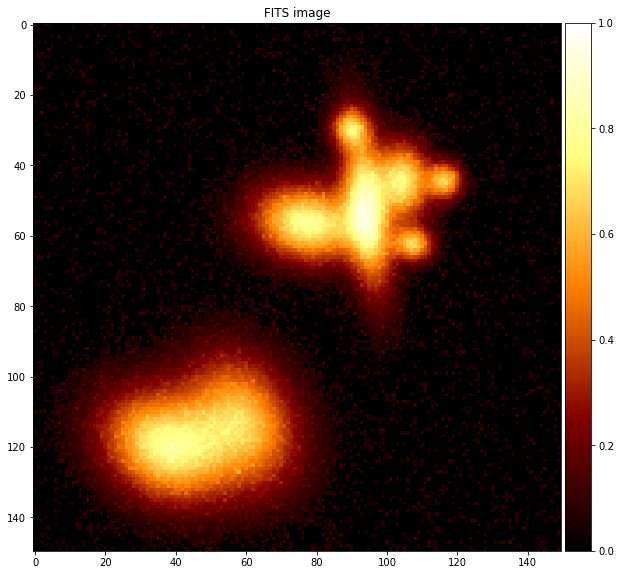

In [21]:
mask = data > 5*rms_noise
d = np.copy(data)
d[~mask] = 0.
image_plot(d)

In [22]:
n_iter = 20
mask = mask.astype(int)
for i in range(n_iter):
    mask = remove_isolate(mask, 0.4, 1, 0) 

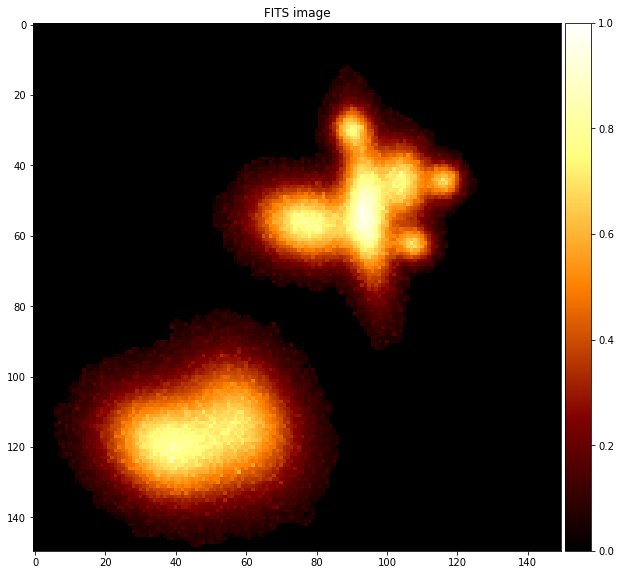

In [23]:
mask = mask.astype(bool)
d = np.copy(data)
d[~mask] = 0.
image_plot(d)

***
***
***

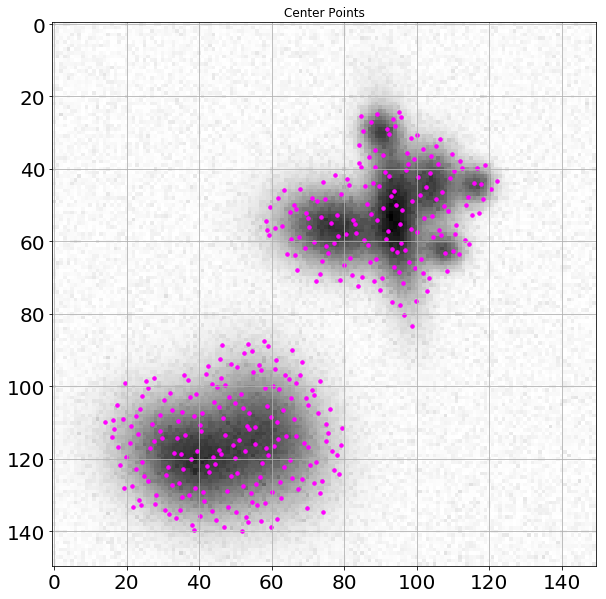

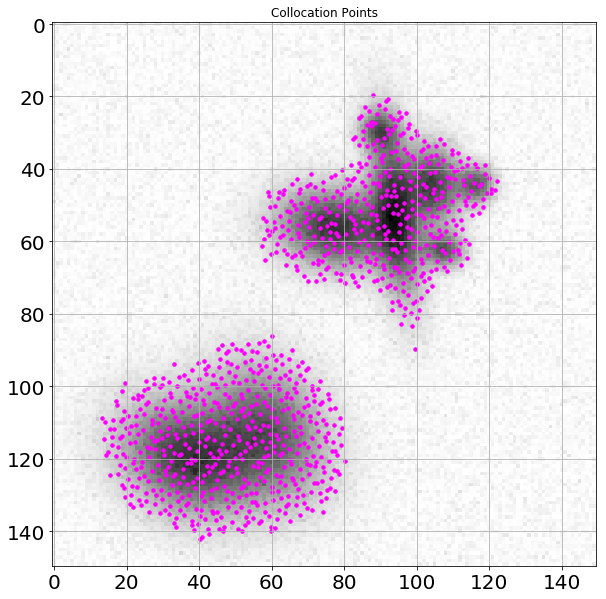

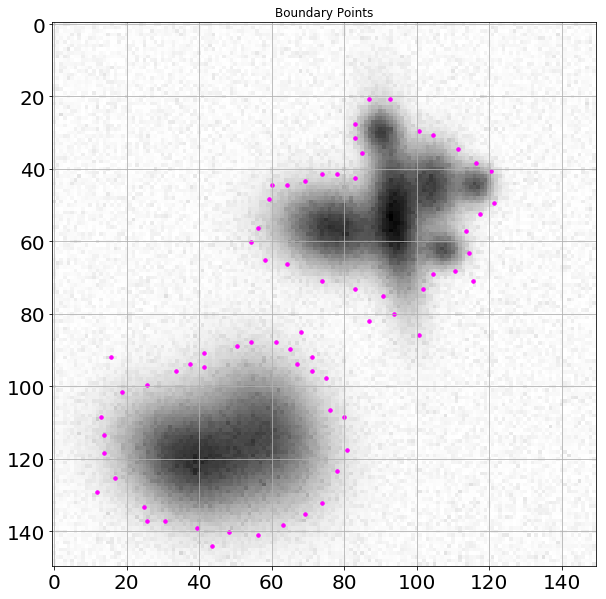

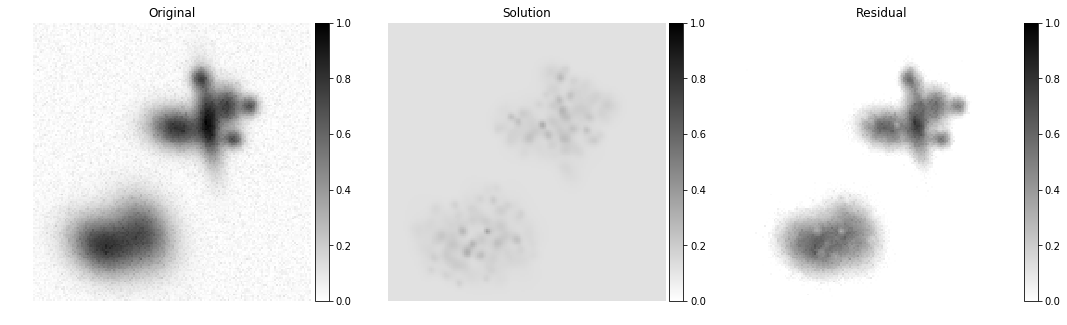

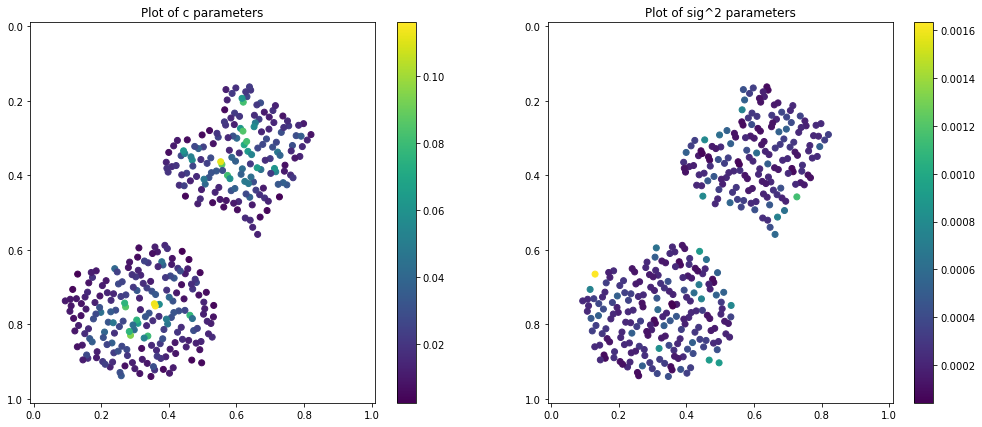

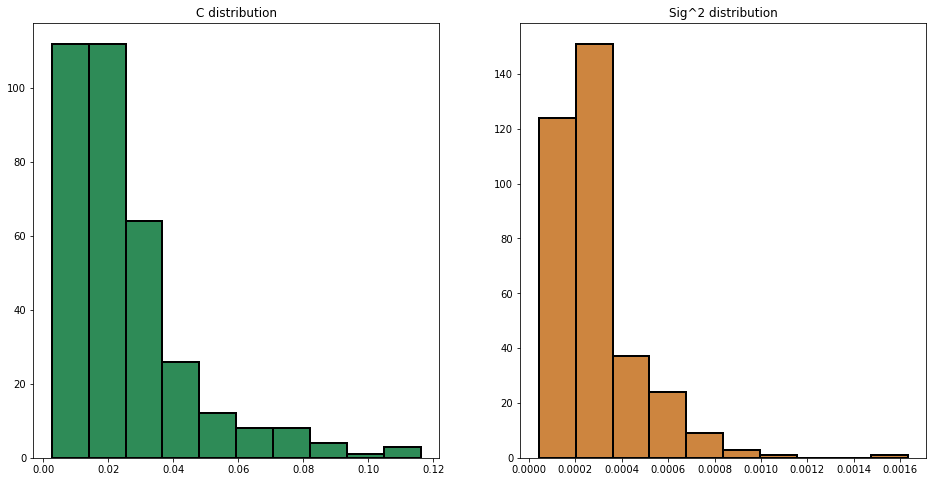

In [33]:
base_level = 0.12
Nc = 350
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 3*Nc - Nb

method=2

if method==1:
    center_points = random_centers_generation(data, Nc, base_level=base_level, power=1.)
    collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    boundary_points = boundary_points_generation(data, base_level, Nb)
elif method==2:
    # points generation
    boundary_points = boundary_points_generation(data, base_level, Nb) 
    Ne = 3*Nc - len(boundary_points)
    points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
    center_points = points[0:Nc]
    collocation_points = points[0:Ne]
      

# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]

# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, center_points=boundary_points, title="Boundary Points")

# Initial parameters estimation
minsig = 3*( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=5.,
                base_level=base_level, pix_freedom=5., minsig=minsig, maxsig=maxsig)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 140100.
nfev: 140129

Residual stats:
Residual RMS: 0.024149923134412634
Residual Variance: 0.0004891526806523705
Flux Lost: 0.03465186964435255
Flux Addition: 0.010171153671993213
psi1(u-f): 0.08078678200971882
Exceeded Pixels: 2041
Sharpness: 193.4122617733531
psi2(grad u): 189.1145888576354
Total elapsed time: 856.9293241500854 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.04979523721469674
Mean min distance between collocation and center points: 0.011451219344402791

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06813225542715819
Max min distance in the (standarized) parameters space: 0.25437698859093183


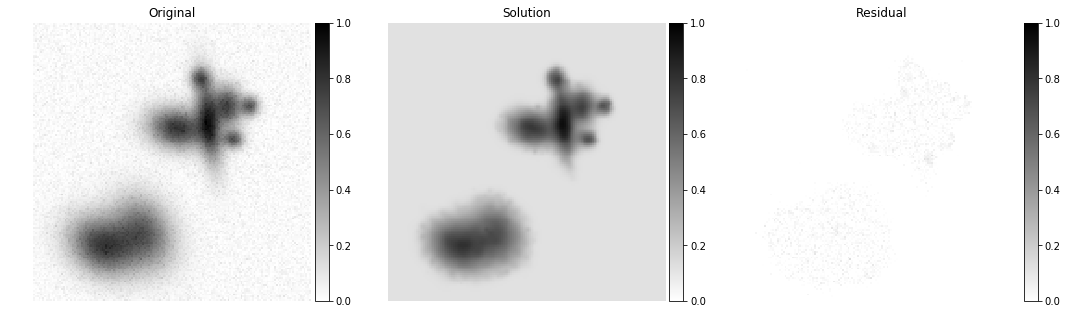

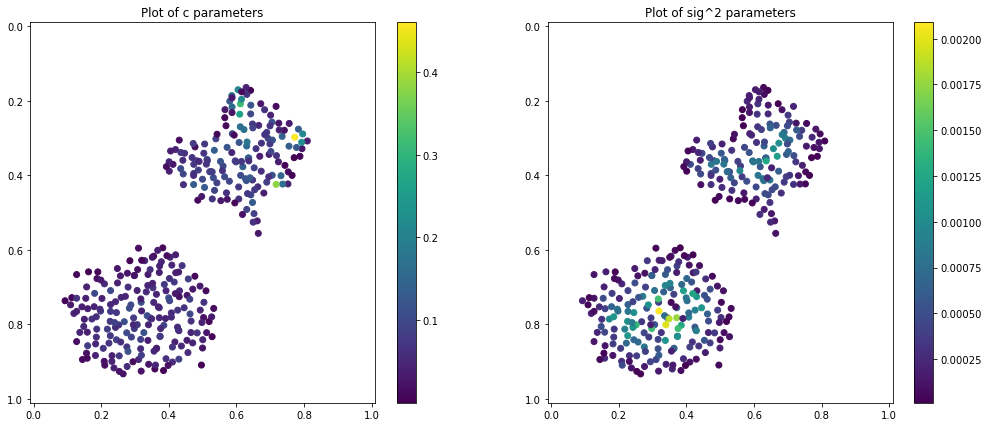

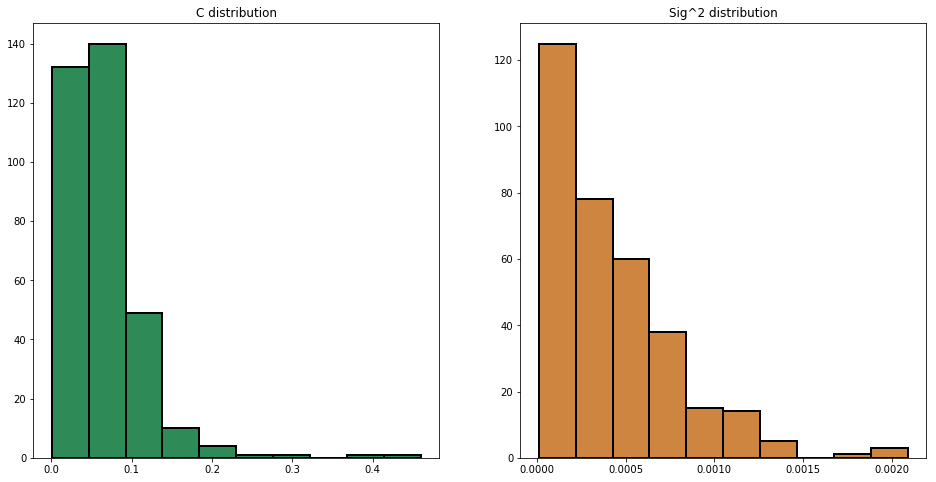

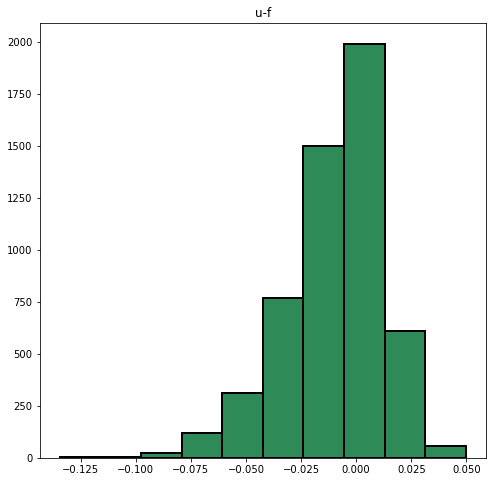

In [34]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

***
***
***


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 135700.
nfev: 135722

Residual stats:
Residual RMS: 0.023237260827225378
Residual Variance: 0.000473919414445039
Flux Lost: 0.031984673879116535
Flux Addition: 0.011470840564912575
psi1(u-f): 0.10515283742552686
Exceeded Pixels: 2180
Sharpness: 194.88524185584134
psi2(grad u): 190.53525887165821
Total elapsed time: 790.3863742351532 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.049292153313779924
Mean min distance between collocation and center points: 0.011679390760616677

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.06735095092444092
Max min distance in the (standarized) parameters space: 0.25475996010117796


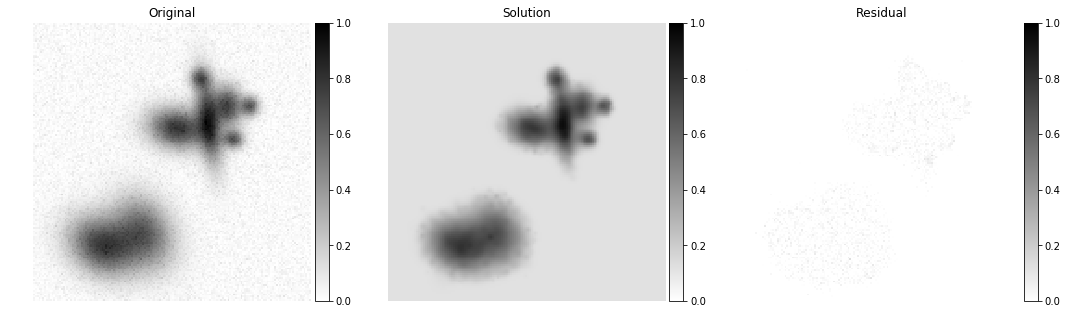

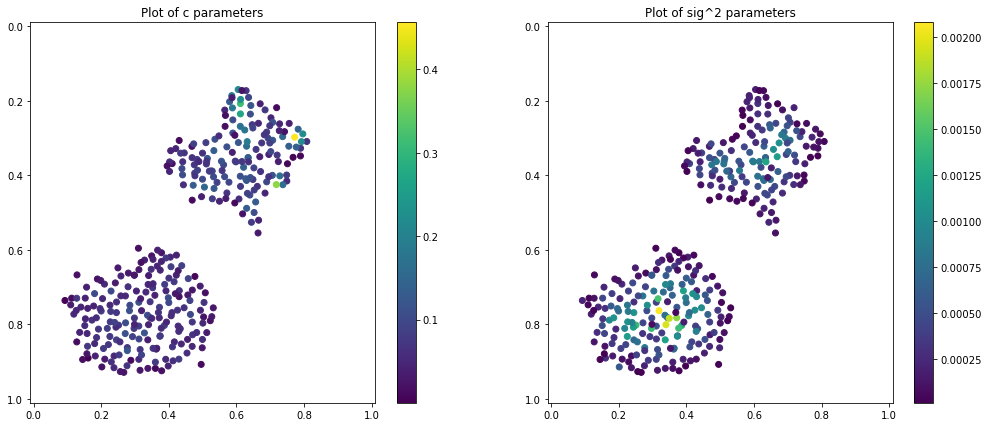

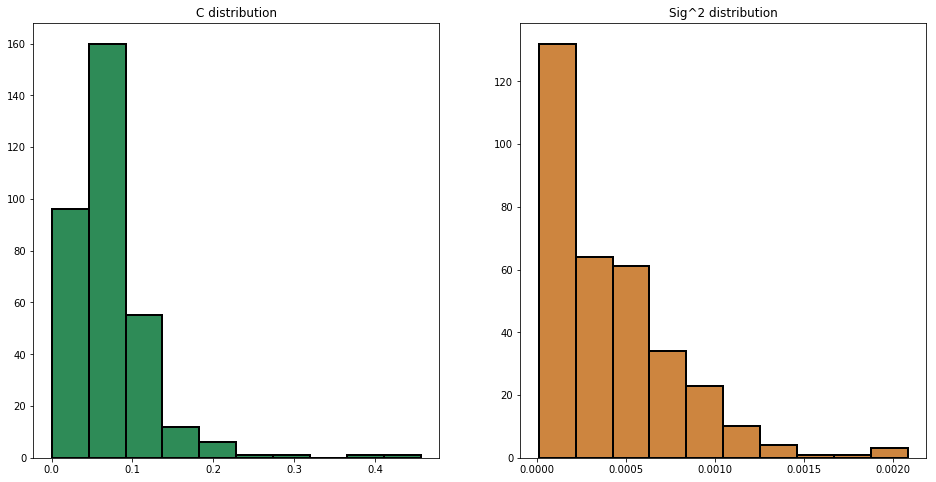

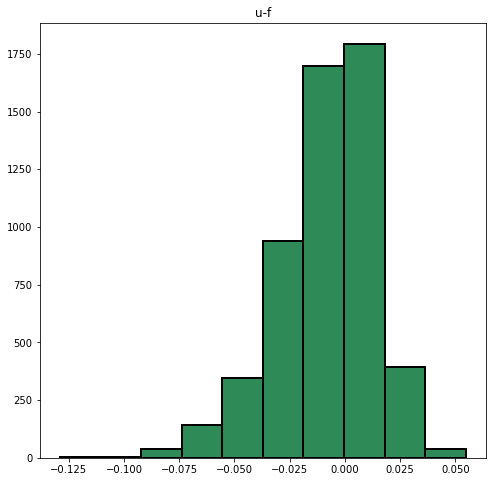

In [35]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [36]:
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

In [37]:
components_dict01, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 234 and 294 with 5.474785315850647e-10 KL dist and 2.2430279476241127e-17 ISD dist
Merged components 23 and 116 with 1.8490233068269024e-07 KL dist and 5.410181444552922e-12 ISD dist
Merged components 81 and 229 with 5.433245335955111e-07 KL dist and 8.596253337655362e-13 ISD dist
Merged components 291 and 316 with 5.574483794444011e-07 KL dist and 1.615643517869758e-10 ISD dist
Merged components 9 and 315 with 6.88634900866843e-07 KL dist and 1.820979515798705e-10 ISD dist
Merged components 173 and 238 with 1.6942029604154023e-06 KL dist and 2.3606846081343676e-10 ISD dist
Merged components 84 and 174 with 2.013421948717539e-06 KL dist and 2.2169299162660916e-09 ISD dist
Merged components 3 and 199 with 2.52566610189503e-06 KL dist and 5.741318077700106e-09 ISD dist
Merged components 223 and 313 with 2.5391362255070547e-06 KL dist and 5.824459500698841e-09 ISD dist
Merged components 15 and 197 with 2.8068909393710627e-06 KL dist and 2.034483038821196e-09 ISD dist
Mer

Merged components 120 and 191 with 2.2411880546420717e-05 KL dist and 1.0681536632699582e-07 ISD dist
Merged components 53 and 197 with 2.2945130851591625e-05 KL dist and 1.0653255345916511e-07 ISD dist
Merged components 29 and 146 with 2.3173463091470583e-05 KL dist and 2.1472024071392043e-08 ISD dist
Merged components 32 and 85 with 2.326823984570697e-05 KL dist and 8.955698746973111e-08 ISD dist
Merged components 112 and 172 with 2.3375931190088104e-05 KL dist and 2.0870133690984381e-07 ISD dist
Merged components 95 and 230 with 2.3492308167622888e-05 KL dist and 2.5801086396113085e-07 ISD dist
Merged components 17 and 53 with 2.3618521544194974e-05 KL dist and 5.7715332700479754e-08 ISD dist
Merged components 84 and 171 with 2.3744378100153205e-05 KL dist and 8.725095493539517e-09 ISD dist
Merged components 57 and 67 with 2.404114016590481e-05 KL dist and 8.998668834243782e-08 ISD dist
Merged components 176 and 185 with 2.4337369084359572e-05 KL dist and 9.884211038996686e-08 ISD d

Merged components 84 and 104 with 6.218160882070622e-05 KL dist and 1.57906955640061e-07 ISD dist
Merged components 24 and 51 with 6.22616148773349e-05 KL dist and 3.878697216580293e-07 ISD dist
Merged components 8 and 106 with 6.324894525071637e-05 KL dist and 9.401138403029082e-08 ISD dist
Merged components 30 and 60 with 6.337291009664119e-05 KL dist and 1.7665546064139044e-07 ISD dist
Merged components 2 and 33 with 6.438150170340459e-05 KL dist and 5.514075489684519e-08 ISD dist
Merged components 113 and 118 with 6.53461321611184e-05 KL dist and 1.8028630077703802e-07 ISD dist
Merged components 62 and 98 with 6.558794981394655e-05 KL dist and 3.1532316138334575e-07 ISD dist
Merged components 25 and 90 with 6.560466891337557e-05 KL dist and 5.744339811395024e-08 ISD dist
Merged components 50 and 86 with 6.689137937031166e-05 KL dist and 3.3335225606513734e-07 ISD dist
Merged components 29 and 96 with 6.765915575040419e-05 KL dist and 1.040888702773322e-08 ISD dist
Merged components

Merged components 30 and 45 with 0.0002807743038505152 KL dist and 5.8914565238299985e-06 ISD dist
Merged components 2 and 53 with 0.0002840697441313009 KL dist and 1.484965604533582e-06 ISD dist
Merged components 10 and 13 with 0.00028522897981148607 KL dist and 3.6876649335252265e-06 ISD dist
Merged components 14 and 33 with 0.00029689608862604536 KL dist and 5.814434380065157e-07 ISD dist
Merged components 8 and 36 with 0.0002973206312514463 KL dist and 2.27645273616761e-06 ISD dist
Merged components 1 and 31 with 0.000301587235694057 KL dist and 1.0744832282743948e-06 ISD dist
Merged components 15 and 49 with 0.00030563375795147375 KL dist and 4.110242531611642e-06 ISD dist
Merged components 9 and 35 with 0.00030909244828674146 KL dist and 2.6331073620786865e-06 ISD dist
Merged components 3 and 35 with 0.00031755398719045 KL dist and 3.020271755559443e-06 ISD dist
Merged components 0 and 25 with 0.0003208783409332904 KL dist and 4.583940407510768e-06 ISD dist
Merged components 7 an

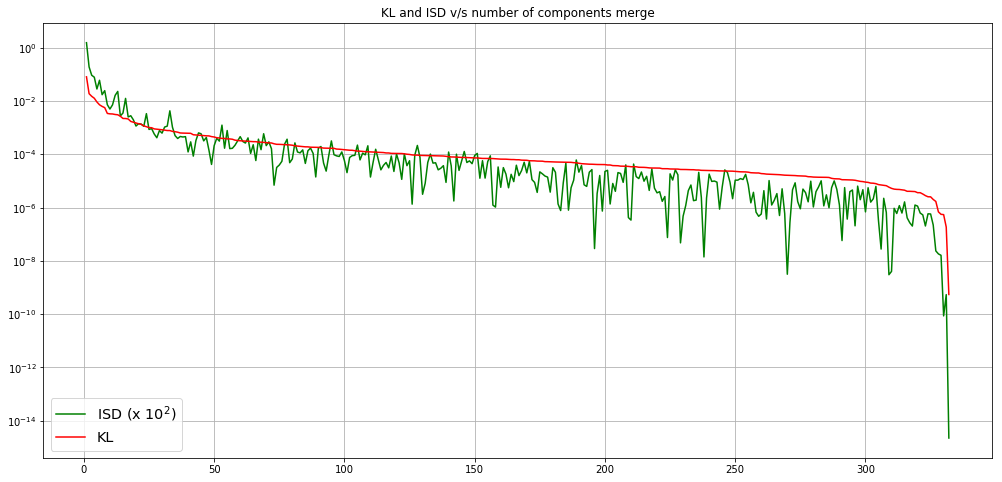

In [38]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.semilogy(ncomp, 1e2*isd_hist, "g-", label='ISD (x$\ 10^2$)')
plt.semilogy(ncomp, kl_hist, "r-", label='KL')
plt.title("KL and ISD v/s number of components merge")
plt.grid()
plt.legend(loc='lower left', fontsize="x-large")
plt.show()

In [40]:
default_ncomp = ncomp_finder(kl_hist)
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01),\
         n_comp=IntSlider(min=1,max=20,value=default_ncomp), n_levels=fixed(1), show_title=fixed(False), 
         save_path=fixed(None),  show_isd=False);

NameError: name 'IntSlider' is not defined

## Images generation

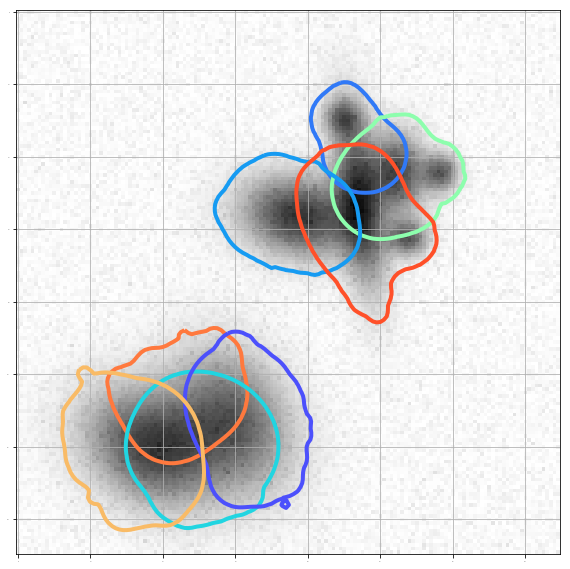

In [46]:
ncomp = 8
components_plot(elm01, components_dict01, n_comp=ncomp, n_levels=1, 
                save_path=target_path+'agglomeration_{0}.eps'.format(ncomp))

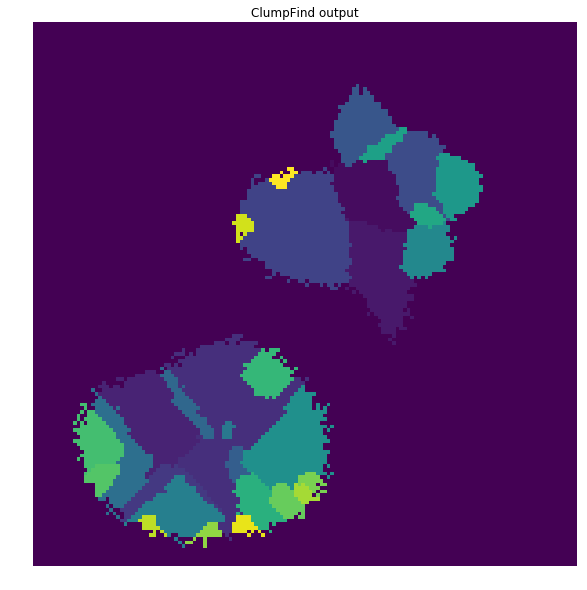

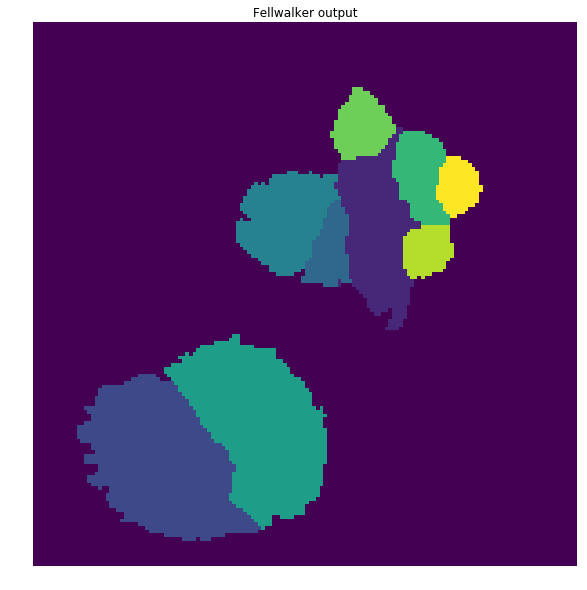

In [13]:
out_cf = clumpfind(data, 0.5*base_level)
out_cf[out_cf==out_cf.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('ClumpFind output')
plt.imshow(out_cf.T)
plt.axis('off')
plt.show()

out_fw = fellwalker(data, 0.5*base_level)
out_fw[out_fw==out_fw.min()] = 0.

plt.figure(figsize=(10,10))
plt.title('Fellwalker output')
plt.imshow(out_fw.T)
plt.axis('off')
plt.show()

***
***
***

## Noise reduction capabilities

In [125]:
base_level = 0.12
Nc = 300
Nb = int(0.2*Nc) #20% of boundary pixels
Ne = 4*Nc - Nb
#alphas = np.arange(0., 3.01, 1.)
alphas = np.linspace(0., 5.01, 0.25)
method = 2

elm_list = []

rms = []
mean = []
var = []

for alpha in alphas:
    if method==1:
        center_points = random_centers_generation(data, Nc, base_level=base_level, power=1.)
        collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
        boundary_points = boundary_points_generation(data, base_level, Nb)
    elif method==2:
        # points generation
        points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
        center_points = points[0:Nc]
        collocation_points = points[0:Ne]
        boundary_points = boundary_points_generation(data, base_level, Nb)   

    # right format
    xc = center_points[:,0]
    yc = center_points[:,1]
    xe = collocation_points[:,0]
    ye = collocation_points[:,1]
    xb = boundary_points[:,0]
    yb = boundary_points[:,1]

    # Initial parameters estimation
    minsig = 3*( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
    maxsig = 30*minsig
    c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')


    elm = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=alpha, lamb1=3.,
                    base_level=base_level, pix_freedom=2., minsig=minsig, maxsig=maxsig)
    
    nfev = 100*(len(elm.get_params())+1)
    elm_solver(elm, method='standard', max_nfev=nfev)
    elm_list.append(elm)
    
    #########################################
    # Computing residual stats
    #########################################
    print("Alpha: {0}".format(alpha))
    u = elm.get_approximation()
    residual = data[elm.mask]-u[elm.mask]
    residual_rms = estimate_rms(residual); print("RMS of residual: {0}".format(residual_rms)); rms.append(residual_rms) 
    residual_mean = np.mean(residual); print("Mean of residual: {0}".format(residual_mean)); mean.append(residual_mean)
    residual_var = np.std(residual)**2; print("Variance of residual: {0} \n".format(residual_var)); var.append(residual_var)

In [126]:
# storing results
f = open( "rms_residual.pkl", "wb" )
pickle.dump(rms, f); f.close()

f = open( "mean_residual.pkl", "wb" )
pickle.dump(mean, f); f.close()

f = open( "var_residual.pkl", "wb" )
pickle.dump(var, f); f.close()

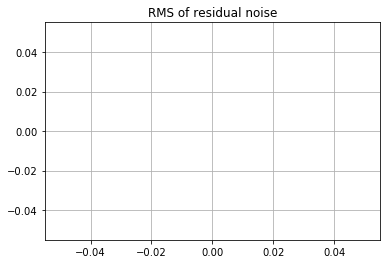

In [127]:
plt.plot(rms, 'bo--')
plt.plot([rms_noise]*len(rms), '-')
plt.grid()
plt.title('RMS of residual noise')
plt.show()

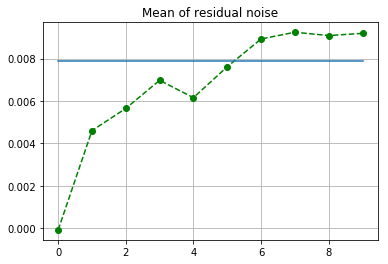

In [22]:
plt.plot(mean, 'go--')
plt.plot([mean_noise]*len(mean), '-')
plt.grid()
plt.title('Mean of residual noise')
plt.show()

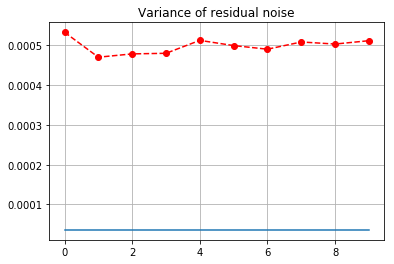

In [23]:
plt.plot(var, 'ro--')
plt.plot([var_noise]*len(var), '-')
plt.grid()
plt.title('Variance of residual noise')
plt.show()

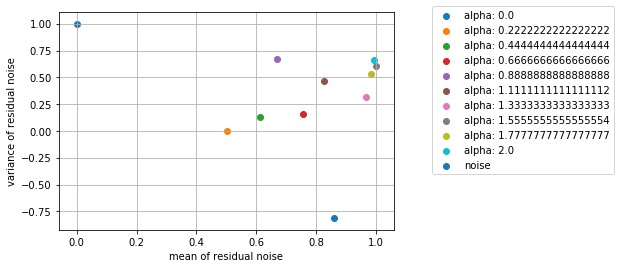

In [24]:
mean = np.array(mean)
_mean = mean - mean.min()
_mean /= _mean.max()

var = np.array(var)
_var = var - var.min()
_var /= _var.max()

for i in range(len(_mean)):
    plt.scatter(_mean[i], _var[i], label='alpha: {0}'.format(alphas[i]))
plt.xlabel('mean of residual noise')
plt.ylabel('variance of residual noise')
plt.grid()


_mean_noise = mean_noise - mean.min()
_mean_noise /= mean.max()

_var_noise = var_noise - var.min()
_var_noise /= var.max()

plt.scatter(_mean_noise, _var_noise, label='noise')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## Final results

In [25]:
r_stats = [elm.residual_stats for elm in elm_list]
sharp = stat_extractor(r_stats, "sharpness")

NameError: name 'elm_list' is not defined

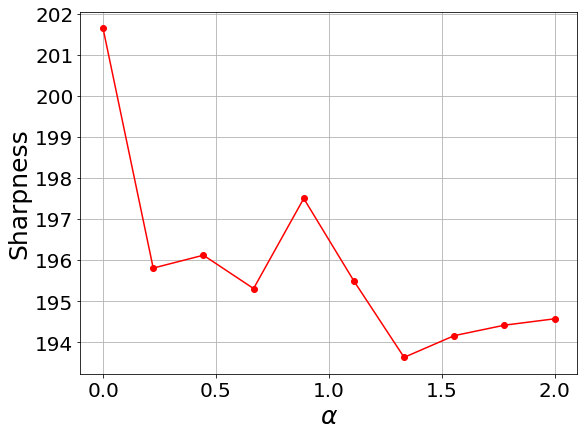

In [94]:
plt.figure(figsize=(8,6))
plt.plot(alphas, sharp, "ro-")
plt.xlabel(r'$\alpha$', size=25)
plt.ylabel('Sharpness', size=25)
plt.grid()
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

In [24]:
for i in range(10):
    elm = elm_list[i]
    u = elm.get_approximation()
    dat = (data-u)[elm.mask]
    plt.figure(figsize=(8,6))
    plt.hist(dat.ravel(), bins=25, facecolor='seagreen', edgecolor='black', lw=2)
    plt.show()

NameError: name 'elm_list' is not defined

In [120]:
elm = elm_list[9]
u = elm.get_approximation()

In [121]:
mask = data-u > 0

In [122]:
dat = (data-u)[elm.mask]

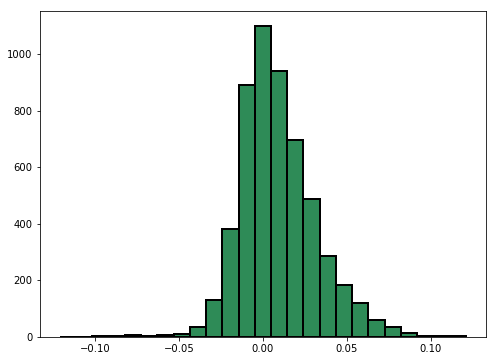

In [123]:
plt.figure(figsize=(8,6))
plt.hist(dat.ravel(), bins=25, facecolor='seagreen', edgecolor='black', lw=2)
plt.show()